 #  Virginia Expungement Data Science Project 

## DS 5559 - Big Data Analytics
* PaulHicks pdh2d
* Mrityunjaya (Jay) Hombal mh4ey
* Sudhanshu Luthras l3zs
* Mahew Dakolios mrd7f 

## Research Question / Hypothesis

The broad problem: In Virginia, if someone is charged (not necessarily convicted, just charged) with a crime (either felony or misdemeanor), they end up with a criminal record that can be found by criminal background checks that employers run when hiring, landlords run when searching for renters, and banks run when deciding whether to issue a loan. So, having a criminal record can keep a person from a job, housing, and financial opportunity. In effect, this situation creates a permanent underclass in society. Criminal record EXPUNGMENT means that the state courts legally hide these records from other members of the public, so that they no longer are findable by criminal background checks. Currently, records are only expungable if a person was never convicted, and records are only expunged after a long and costly bureaucratic process. That's changing however: in the current legislative session happening right now there are several bills under consideration to expand what is expungable and to make expungement automatic for people with certain kinds of records. Still, there are many unaddressed questions about the nature of expungement and law enforcement (see below for the LAJC's questions), and limitations on the data that can be used to answer these questions.



## Setup

In [1]:
# setup
'''
LOCAL and COLLAB, ONLY one of the two environements should be set True.
'''
# running on local desktop
LOCAL = True

# running on UVA collab
UVA_COLAB = False

# setup environment variables
%run -i setup.py

# load va file data load script
%run  -i va_court_files_download.py

VA file download script loaded!


In [2]:
import os, sys
# import all required libraries
%run -i settings.py
#import all utility functions
%run -i utility-functions.py

Imports and display options set...


In [3]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2

# you can now enable 2x images by just adding the line:
# see: https://gist.github.com/minrk/3301035
%config InlineBackend.figure_format = 'png'

## Download and Merge Circuit Court Records (10 years)

In [4]:
# download and concat circuit court data from 2009 to 2019 into a dataset and persist to csv
download_and_merge_court_data('circuit')

data directory already existis, files will be deleted
./data/circuit_court_2009_2019.csv.gz file does not exist!
circuit court file download path : ./download-data/circuit
directory does not exist
download directory ./download-data/circuit created
start circuit court files download...
downloading file https://s3.amazonaws.com/virginia-court-data/circuit_criminal_2019_anon_YNA8S7.zip 
downloading file https://s3.amazonaws.com/virginia-court-data/circuit_criminal_2018_anon_1GI9Q0.zip 
downloading file https://s3.amazonaws.com/virginia-court-data/circuit_criminal_2017_anon_VKJSJ2.zip 
downloading file https://s3.amazonaws.com/virginia-court-data/circuit_criminal_2016_anon_712ZX2.zip 
downloading file https://s3.amazonaws.com/virginia-court-data/circuit_criminal_2015_anon_S9DA5G.zip 
downloading file https://s3.amazonaws.com/virginia-court-data/circuit_criminal_2014_anon_VSE5UB.zip 
downloading file https://s3.amazonaws.com/virginia-court-data/circuit_criminal_2013_anon_3BWWKM.zip 
downloa

## Load Merged Dataset

In [5]:
# Load merged circuit court file
file = f'{BASE_DIR}/data/circuit_court_2009_2019.csv.gz'
df = pd.read_csv(file, parse_dates =['offense_date'])
df.head(5)

,person_id,offense_date,final_disposition,fips,gender,race,class,charge_type,ammended_charge_type
0,152051000000121,2007-01-09,Nolle Prosequi,99,Female,White Caucasian (Non-Hispanic),NaN,Felony,NaN
1,152051000000121,2007-01-09,Nolle Prosequi,99,Female,White Caucasian (Non-Hispanic),NaN,Felony,NaN
2,152051000000121,2007-01-09,Nolle Prosequi,99,Female,White Caucasian (Non-Hispanic),NaN,Felony,NaN
3,152051000000121,2007-01-09,Nolle Prosequi,99,Female,White Caucasian (Non-Hispanic),NaN,Felony,NaN
4,152051000000121,2006-12-13,Sentence/Probation Revoked,99,Female,White Caucasian (Non-Hispanic),NaN,Felony,NaN


### Summary Statistics

In [6]:
# In this example, the data frame is described and [‘object’] is passed to include parameter
# to see description of object series. [.20, .40, .60, .80] is passed to percentile parameter 
# to view the respective percentile of Numeric series.
# see: https://www.geeksforgeeks.org/python-pandas-dataframe-describe-method/
perc = [0.20, .40, .60, 0.80]
include = ['object', 'float', 'int']
df.describe(percentiles= perc, include=include).T

,count,unique,top,freq
offense_date,1990315,11192,2013-03-26,1624
final_disposition,1933598,12,Guilty,873527
gender,1990315,2,Male,1496894
race,1987177,10,White Caucasian (Non-Hispanic),987196
class,1489945,8,U,739442
charge_type,1990315,6,Felony,1388595
ammended_charge_type,167939,5,Misdemeanor,103012


**Observations:**  
**TODO** - need to update 
* largest numbers of hearings on a given day - 2267 hearings were scheduled on 2019-05-06,
* Max number of cases (987196) were filed White Caucasian (Non-Hispanic) race

## Data Cleaning

### Check for missing values

In [7]:
# number of na values in each column
df.isna().sum()

person_id                     0
offense_date                  0
final_disposition         56717
fips                          0
gender                        0
race                       3138
class                    500370
charge_type                   0
ammended_charge_type    1822376
dtype: int64

In [8]:
df['race'].unique()

array(['White Caucasian (Non-Hispanic)', 'Black (Non-Hispanic)',
       'Hispanic', 'Other (Includes Not Applicable, Unknown)',
       'Asian Or Pacific Islander', nan, 'American Indian', 'White',
       'Black', 'Unknown', 'American Indian Or Alaskan Native'],
      dtype=object)

Following are the valid races from the data dictionary at https://medium.com/@virginiacourtdata/virginia-court-data-fields-e224a9a41e15#.qkeo5r6ds.

[“American Indian”   
 “Asian Or Pacific Islander”   
 “Black (Non-Hispanic)”  
 “Hispanic”   
 “Other (Includes Not Applicable, Unknown)”  
 “White Caucasian (Non-Hispanic)” ]  

The circuit-court data contains 'Black', 'white', 'nan' values, so we are making assumption the following assumptions

1. The 'nan' value will be treated as missing value and will be imputed to "Other (Includes Not Applicable, Unknown)"  case
2. The 'White' value will be treated as  'White Caucasian (Non-Hispanic)'
3. The 'Black' value will be treated as  'White Caucasian (Non-Hispanic)'
4. The 'Unkown' value will be treated as 

In [9]:
df.loc[df['race'] == 'White', 'race'] = 'White Caucasian (Non-Hispanic)' 
df.loc[df['race'] == 'Black', 'race'] = 'Black (Non-Hispanic)' 
df.loc[df['race'] == 'Unknown', 'race'] = 'Other (Includes Not Applicable, Unknown)'
df.loc[df['race'].isna(), 'race'] = 'Other (Includes Not Applicable, Unknown)'
df['race'].unique()

array(['White Caucasian (Non-Hispanic)', 'Black (Non-Hispanic)',
       'Hispanic', 'Other (Includes Not Applicable, Unknown)',
       'Asian Or Pacific Islander', 'American Indian',
       'American Indian Or Alaskan Native'], dtype=object)

In [10]:
df['final_disposition'].unique()

array(['Nolle Prosequi', 'Sentence/Probation Revoked', 'Guilty',
       'Dismissed', 'Not Guilty/Acquitted', nan, 'Appeal Withdrawn',
       'Not True Bill', 'Remanded', 'No Indictment Presented', 'Mistrial',
       'Resolved', 'Not Guilty By Reason Of Insanity'], dtype=object)

Following are the valid races from the data dictionary at https://medium.com/@virginiacourtdata/virginia-court-data-fields-e224a9a41e15#.qkeo5r6ds.

**FinalDisposition**  
[“Appeal Withdrawn”  
“Dismissed”  
“Guilty”  
“Mistrial”  
“No Indictment Presented”  
“Nolle Prosequi”  
“Not Guilty/Acquitted”  
“Not Guilty By Reason Of Insanity”  
“Not True Bill”  
“Remanded”  
“Resolved”  
“Sentence/Probation Revoked”]     

In [11]:
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [12]:
#Possible values from doc metadata ChargeType “Civil” “F” “Felony” “Infraction” “Misdemeanor” “Other (Animal Violations, Bond Appeals)”
df['charge_type'].unique()

array(['Felony', 'Misdemeanor', 'Infraction',
       'Other (Animal Violations, Bond Appeals)', 'Civil', 'F'],
      dtype=object)

In [13]:
df.groupby('charge_type').count()

,person_id,offense_date,final_disposition,fips,gender,race,class,ammended_charge_type
charge_type,,,,,,,,
Civil,6200,6200,5949,6200,6200,6200,2681,53
F,1,1,0,1,1,1,0,0
Felony,1388595,1388595,1346959,1388595,1388595,1388595,1098398,129672
Infraction,76609,76609,76153,76609,76609,76609,23649,9373
Misdemeanor,462438,462438,450306,462438,462438,462438,364985,28833
"Other (Animal Violations, Bond Appeals)",56472,56472,54231,56472,56472,56472,232,8


In [14]:
#Possible values from doc metadata ChargeType “Civil” “F” “Felony” “Infraction” “Misdemeanor” “Other (Animal Violations, Bond Appeals)”
df['ammended_charge_type'].unique()

array([nan, 'Misdemeanor', 'Felony', 'Infraction',
       'Other (Animal Violations, Bond Appeals)', 'Civil'], dtype=object)

**Note:**  
For our study, **'person_id', 'offense_date', 'final_disposition', 'fips', 'race', 'gender', and 'charge_type'** are mandatory columns.
So removing all records where these field values are missing will be removed

In [15]:
df.dropna(axis=0, subset=['person_id', 'offense_date', 'final_disposition', 'fips', 'class',\
                          'race', 'gender', 'charge_type',],\
                          inplace=True)
print(f"Num of records after cleaning missing data {len(df)}")

Num of records after cleaning missing data 1443699


In [16]:
# for the moment we consider case_class as important field, so we will impute missing value 'unknown'
df['ammended_charge_type'].fillna('unknown', inplace=True)

In [17]:
# validating for missing data again
df.isna().sum()

person_id               0
offense_date            0
final_disposition       0
fips                    0
gender                  0
race                    0
class                   0
charge_type             0
ammended_charge_type    0
dtype: int64

### Check for duplicate records

In [18]:
duplicate_records = pd.DataFrame(df.duplicated(), columns=['isduplicate'])
duplicate_records = duplicate_records.reset_index()
duplicate_records.columns = [str(column) for column in duplicate_records.columns]
duplicate_records.set_index('index')
duplicate_records.groupby('isduplicate').count()

,index
isduplicate,
False,1123044
True,320655


**TODO:** Our dataset has X duplicate records, so we purge these records from our dataset

In [19]:
#drop duplicate records
df = df.drop_duplicates(['person_id', 'offense_date', 'final_disposition', 'fips', 'race', 'gender', 'ammended_charge_type'])
len(df)

984062

## Preprocessing Data

### Adding fips_area name column

**Note**: FIPS Code file that I am using has duplicates resulting in Cartesian product, for now commenting the code

In [20]:
#load fips code table
fips_file = 'reference-data/va-fips-codes.csv'
fips_df = pd.read_csv(fips_file)
fips_df

,fips,name
0,1,Accomack Circuit Court
1,3,Albemarle Circuit Court
2,5,Alleghany Circuit Court
3,7,Amelia Circuit Court
4,9,Amherst Circuit Court
...,...,...
114,800,Suffolk Circuit Court
115,810,Virginia Beach Circuit Court
116,820,Waynesboro Circuit Court
117,830,Williamsburg/James City County Circuit Court


In [21]:
# #add fips_area
df = pd.merge(df,fips_df, on='fips', how='left')\
    .rename(columns={'name': 'fips_area'})
df.head()

,person_id,offense_date,final_disposition,fips,gender,race,class,charge_type,ammended_charge_type,fips_area
0,141170000000472,2009-01-09,Guilty,99,Male,White Caucasian (Non-Hispanic),6,Felony,unknown,King George Circuit Court
1,28110000000310,2009-04-27,Guilty,99,Male,White Caucasian (Non-Hispanic),5,Felony,unknown,King George Circuit Court
2,333221000000063,2009-06-12,Guilty,99,Female,White Caucasian (Non-Hispanic),5,Felony,unknown,King George Circuit Court
3,259101000000198,2009-06-09,Guilty,99,Female,Black (Non-Hispanic),1,Misdemeanor,unknown,King George Circuit Court
4,131120000001148,2009-05-06,Guilty,99,Male,White Caucasian (Non-Hispanic),1,Misdemeanor,unknown,King George Circuit Court


### Adding candidate column

In [22]:
cand_list =['Dismissed','Noile Prosequi','Not Guilty', 'Withdrawn', 'Not Found', 'No Indictment Presented', 'No Longer Under Advisement', 'Not True Bill']
df['candidate'] = [1 if x in cand_list else 0 for x in df['final_disposition']]

In [23]:
df.sample(10)

,person_id,offense_date,final_disposition,fips,gender,race,class,charge_type,ammended_charge_type,fips_area,candidate
74099,233070000000034,2009-08-25,Guilty,690,Male,Black (Non-Hispanic),U,Felony,unknown,Martinsville Circuit Court,0
220288,361151000000260,2011-11-01,Sentence/Probation Revoked,550,Female,White Caucasian (Non-Hispanic),U,Felony,unknown,Chesapeake Circuit Court,0
225969,291020000000220,2012-06-04,Sentence/Probation Revoked,810,Male,White Caucasian (Non-Hispanic),U,Felony,unknown,Virginia Beach Circuit Court,0
243217,262131000000047,2010-04-02,Guilty,700,Female,White Caucasian (Non-Hispanic),2,Felony,Felony,Newport News Circuit Court,0
236432,332011000000557,2012-05-30,Guilty,820,Female,White Caucasian (Non-Hispanic),5,Felony,unknown,Waynesboro Circuit Court,0
133932,184180000000792,2011-07-25,Nolle Prosequi,760,Male,Black (Non-Hispanic),U,Felony,unknown,Richmond City Circuit Court,0
729661,205060000000475,2017-03-05,Guilty,73,Male,White Caucasian (Non-Hispanic),U,Misdemeanor,unknown,Gloucester Circuit Court,0
2089,300010000000864,2004-11-09,Nolle Prosequi,760,Male,White Caucasian (Non-Hispanic),U,Felony,unknown,Richmond City Circuit Court,0
442974,117070000000298,2014-02-03,Dismissed,187,Male,White Caucasian (Non-Hispanic),U,Felony,unknown,Warren Circuit Court,1
466553,57190000000276,2013-09-24,Guilty,550,Male,White Caucasian (Non-Hispanic),5,Felony,unknown,Chesapeake Circuit Court,0


In [24]:
df[df['person_id'] == 1000000000053]

,person_id,offense_date,final_disposition,fips,gender,race,class,charge_type,ammended_charge_type,fips_area,candidate
443918,1000000000053,2014-07-08,Guilty,61,Male,Black (Non-Hispanic),1,Misdemeanor,unknown,Fauquier Circuit Court,0


In [25]:
df[df['person_id'] == 152051000000121]

,person_id,offense_date,final_disposition,fips,gender,race,class,charge_type,ammended_charge_type,fips_area,candidate


**TODO:** If the charges are ammended to DWI then also it can be a candidate for expungement if the person does not have any prior felony charges 

### Saving Cleaned Data & Delete the large Merged File

In [26]:
df.to_csv(
    PROCESSED_PATH + "circuit_court_2009_2019_cleansed.csv.gz",
    index=False,
    compression="gzip",
    header=True,
    quotechar='"',
    doublequote=True,
    line_terminator="\n",
)

delete_file(PROCESSED_PATH + "circuit_court_2009_2019.csv.gz")

./data/circuit_court_2009_2019.csv.gz file removed successfully!


## Exploratory Data Analysis

**Note to Team:** You can execute the above code once and start from Exploratory Data Analysis, execute first three lines

In [27]:
# Load the cleaned data file
file = f'{BASE_DIR}/data/circuit_court_2009_2019_cleansed.csv.gz'
cleansed_df = pd.read_csv(file, parse_dates =['offense_date'])
cleansed_df.head(5)
df = cleansed_df

In [28]:
df.head()

,person_id,offense_date,final_disposition,fips,gender,race,class,charge_type,ammended_charge_type,fips_area,candidate
0,141170000000472,2009-01-09,Guilty,99,Male,White Caucasian (Non-Hispanic),6,Felony,unknown,King George Circuit Court,0
1,28110000000310,2009-04-27,Guilty,99,Male,White Caucasian (Non-Hispanic),5,Felony,unknown,King George Circuit Court,0
2,333221000000063,2009-06-12,Guilty,99,Female,White Caucasian (Non-Hispanic),5,Felony,unknown,King George Circuit Court,0
3,259101000000198,2009-06-09,Guilty,99,Female,Black (Non-Hispanic),1,Misdemeanor,unknown,King George Circuit Court,0
4,131120000001148,2009-05-06,Guilty,99,Male,White Caucasian (Non-Hispanic),1,Misdemeanor,unknown,King George Circuit Court,0


**Top 20 final_disposition result**

<AxesSubplot:>

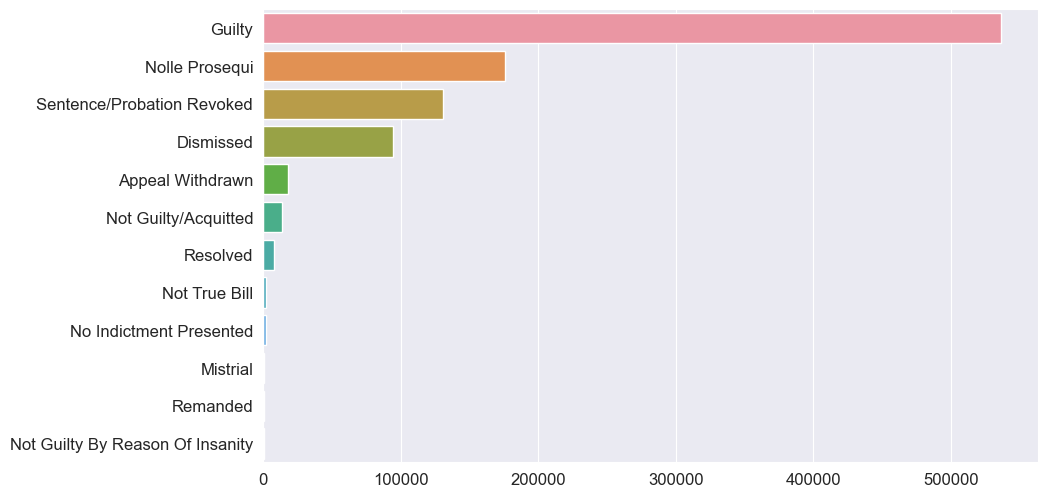

In [29]:
hearing_result_counts = df['final_disposition'].value_counts()
subset = hearing_result_counts[:15]
sns.barplot(y=subset.index, x=subset.values)

**Top 20 final_disposition by gender**

<AxesSubplot:xlabel='total', ylabel='final_disposition'>

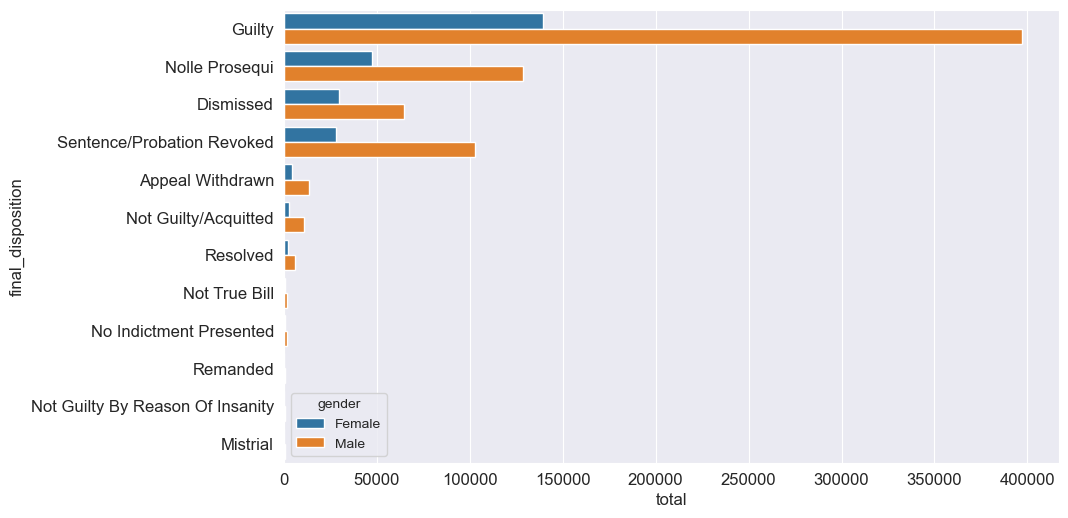

In [30]:
df_result_bygendger = df.groupby(['final_disposition', 'gender'])\
                        .size()\
                        .unstack()\
                        .fillna(0)\
                        .sort_values(['Female', 'Male'], ascending=False)
df_stacked = df_result_bygendger.head(15).stack()
df_stacked.name = 'total'
df_stacked= df_stacked.reset_index()
sns.barplot(x='total', y='final_disposition', hue='gender', data= df_stacked)

In [31]:
candidate_count = df['candidate'].groupby([df['gender'],df['race']]).count()
candidate_count

gender  race                                    
Female  American Indian                                101
        American Indian Or Alaskan Native               11
        Asian Or Pacific Islander                     1022
        Black (Non-Hispanic)                         79497
        Hispanic                                       856
        Other (Includes Not Applicable, Unknown)      2875
        White Caucasian (Non-Hispanic)              171305
Male    American Indian                                354
        American Indian Or Alaskan Native               27
        Asian Or Pacific Islander                     3212
        Black (Non-Hispanic)                        323804
        Hispanic                                      5939
        Other (Includes Not Applicable, Unknown)      7687
        White Caucasian (Non-Hispanic)              387372
Name: candidate, dtype: int64

In [32]:
df['candidate'].groupby(df['gender']).count()

gender
Female    255667
Male      728395
Name: candidate, dtype: int64

**TODO** document observations based on above data

In [79]:
# set RIVANA to True if running on UVA Rivana apache spark Node 
RIVANA = False

if RIVANA != True:
    import findspark
    findspark.init()

In [80]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [81]:
app_name = 'va_expungement'

if RIVANA != True:
    # update spark_master to your master local IP and port
    spark_master = "spark://10.143.158.50:7077"
    spark = SparkSession\
        .builder\
        .config('spark.executor.memory', '2g')\
        .config('spark.executor.cores', '2')\
        .config('spark.cores.max', '24')\
        .config('spark.cores.min', '20')\
        .config('spark.driver.memory', '8g')\
        .config("spark.local.dir", "C:/tmp/hive")\
        .appName(app_name)\
        .master(spark_master)\
        .getOrCreate()
elif RIVANA == True:
    spark = SparkSession \
        .builder \
        .master("local") \
        .appName(app_name) \
        .config("spark.executor.memory", '8g') \
        .config('spark.executor.cores', '4') \
        .config('spark.cores.max', '4') \
        .config("spark.driver.memory",'8g') \
        .getOrCreate()

In [82]:
file = f'{BASE_DIR}/data/circuit_court_2009_2019_cleansed.csv.gz'

schema = StructType([
    StructField('person_id', LongType(), False),
    StructField('offense_date', DateType(), False),
    StructField('final_disposition', StringType(), False),
    StructField('fips', IntegerType(), False),
    StructField('gender', StringType(), False),
    StructField('race', StringType(), False),
    StructField('class', StringType(), False),
    StructField('charge_type', StringType(), False),
    StructField('ammended_charge_type', StringType(), False),
    StructField('fips_area', StringType(), False),
    StructField('candidate', IntegerType(), False)
])

circuit_df = (spark.read.schema(schema)
             .format("csv")
             .option("inferSchema", True)
             .option("header", True)
             .load(file))


**Basic Data Analysis**

 From the above analysis we see the following condition in the data  
 - The charge column is free form text, charge_type is categorical. The same person can be charges one more times on the same day or on different days on multiple counts  
 - however since we are not able to use charge as a predictor variable using only charge_types will result in multiple record for the same person (by person_id)  
 - so to minimize the noise in the data we will introduce a variable called 'repeat_offender', this will be 1 if a person has felony or otherwise  

In [83]:
circuit_df.count()

984062

In [84]:
# add where condition where case_type is not 
repeat_offenders = circuit_df.groupBy('person_id').count().orderBy('count', ascending=False)
repeat_offenders = repeat_offenders.withColumnRenamed("count", "rpt_offense_ct")
repeat_offenders.show(5)

+---------------+--------------+
|      person_id|rpt_offense_ct|
+---------------+--------------+
|213011000000129|           320|
|141010000000236|           157|
|101141000000123|           127|
|  4150000000636|           125|
|262020000000221|           121|
+---------------+--------------+
only showing top 5 rows



In [86]:
circuit_df.createOrReplaceTempView("cc_case")
repeat_offenders.createOrReplaceTempView("cc_rpt_offender")

In [87]:
#circuit_df = circuit_df.join(repeat_offenders,circuit_df.person_id ==  repeat_offenders.person_id,"left")
#circuit_df.show(1)
circuit_df = spark.sql('''select cc_case.person_id,  cc_case.offense_date, cc_case.final_disposition, cc_case.fips,
            cc_case.gender, cc_case.race, cc_case.class, cc_case.charge_type, cc_case.ammended_charge_type, 
            cc_case.fips_area, cc_case.candidate, cc_rpt_offender.rpt_offense_ct
            from cc_case, cc_rpt_offender where cc_case.person_id == cc_rpt_offender.person_id''')
circuit_df.head()

Row(person_id=141170000000472, offense_date=datetime.date(2009, 1, 9), final_disposition='Guilty', fips=99, gender='Male', race='White Caucasian (Non-Hispanic)', class='6', charge_type='Felony', ammended_charge_type='unknown', fips_area='King George Circuit Court', candidate=0, rpt_offense_ct=11)

In [88]:
circuit_df = circuit_df\
    .withColumn('repeat_offender', expr("CASE WHEN rpt_offense_ct > 1 THEN 1 ELSE 0 END"))\
    .drop('rpt_offense_ct')

In [89]:
circuit_df.createOrReplaceTempView("cc_case")
circuit_df.head()

Row(person_id=141170000000472, offense_date=datetime.date(2009, 1, 9), final_disposition='Guilty', fips=99, gender='Male', race='White Caucasian (Non-Hispanic)', class='6', charge_type='Felony', ammended_charge_type='unknown', fips_area='King George Circuit Court', candidate=0, repeat_offender=1)

In [90]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf

def encode_class_and_chargetype(case_class, charge_type):
    if charge_type == 'Felony':
            if case_class == "1":
                return 11
            elif case_class == "2":
                return 10
            elif case_class == "3":
                return 9
            elif case_class == "4":
                return 7
            elif case_class == "5":
                return 6
            elif case_class == "6":
                return 5
            elif case_class == "O":
                return 8
            elif case_class == "U":
                return 8
            else:
                return 0
    elif charge_type == 'Misdemeanor':
            if case_class == "1":
                return 4
            elif case_class == "2":
                return 3
            elif case_class == "3":
                return 2
            elif case_class == "4":
                return 1
            else:
                return 0


In [91]:
encode_udf = udf(encode_class_and_chargetype, IntegerType())
circuit_df = circuit_df.withColumn('case_charge_type_enc', encode_udf('class', 'charge_type'))

In [92]:
circuit_df.head()

Row(person_id=141170000000472, offense_date=datetime.date(2009, 1, 9), final_disposition='Guilty', fips=99, gender='Male', race='White Caucasian (Non-Hispanic)', class='6', charge_type='Felony', ammended_charge_type='unknown', fips_area='King George Circuit Court', candidate=0, repeat_offender=1, case_charge_type_enc=5)

In [93]:
#retain only 'Felony', 'Misdemeanor' cases
circuit_df.createOrReplaceTempView("cc_case")
circuit_df = spark.sql ("select * from cc_case where charge_type in ('Felony', 'Misdemeanor')")
circuit_df.count()

962748

In [94]:
circuit_df.printSchema()

root
 |-- person_id: long (nullable = true)
 |-- offense_date: date (nullable = true)
 |-- final_disposition: string (nullable = true)
 |-- fips: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- race: string (nullable = true)
 |-- class: string (nullable = true)
 |-- charge_type: string (nullable = true)
 |-- ammended_charge_type: string (nullable = true)
 |-- fips_area: string (nullable = true)
 |-- candidate: integer (nullable = true)
 |-- repeat_offender: integer (nullable = false)
 |-- case_charge_type_enc: integer (nullable = true)



In [95]:
circuit_df.toPandas().to_csv(
    PROCESSED_PATH + "circuit_court_2009_2019_transformed.csv.gz",
    index=False,
    compression="gzip",
    header=True,
    quotechar='"',
    doublequote=True,
    line_terminator="\n",
)

#delete_file(PROCESSED_PATH + "circuit_court_2009_2019_cleansed.csv.gz")

In [97]:
tempdf  = circuit_df.select('person_id', 'repeat_offender', 'case_charge_type_enc', 'candidate')

In [98]:
tempdf.sample(False, 0.0001).show(10)

+---------------+---------------+--------------------+---------+
|      person_id|repeat_offender|case_charge_type_enc|candidate|
+---------------+---------------+--------------------+---------+
| 61131000000101|              1|                   6|        0|
| 10040000000265|              1|                   5|        0|
|212030000000116|              0|                   8|        0|
|302010000000568|              0|                   6|        0|
| 32021000000472|              0|                   5|        0|
| 14120000000646|              0|                   5|        0|
| 22150000000373|              0|                   8|        0|
| 34170000000301|              1|                   5|        0|
|169090000000125|              1|                   8|        0|
| 32180000000440|              1|                   6|        0|
+---------------+---------------+--------------------+---------+
only showing top 10 rows



In [99]:
spark.sql('''SELECT person_id, offense_date, final_disposition, race, gender, class, charge_type, repeat_offender
    FROM cc_case
    WHERE person_id = 2170000000014
    ORDER by offense_date''').show(25, True)

#213011000000129

+-------------+------------+-----------------+--------------------+------+-----+-----------+---------------+
|    person_id|offense_date|final_disposition|                race|gender|class|charge_type|repeat_offender|
+-------------+------------+-----------------+--------------------+------+-----+-----------+---------------+
|2170000000014|  2009-03-22|           Guilty|White Caucasian (...|  Male|    5|     Felony|              1|
|2170000000014|  2012-02-07|        Dismissed|White Caucasian (...|  Male|    5|     Felony|              1|
|2170000000014|  2012-03-01|   Nolle Prosequi|White Caucasian (...|  Male|    5|     Felony|              1|
|2170000000014|  2012-03-03|           Guilty|White Caucasian (...|  Male|    5|     Felony|              1|
|2170000000014|  2012-03-05|           Guilty|White Caucasian (...|  Male|    5|     Felony|              1|
|2170000000014|  2012-03-06|           Guilty|White Caucasian (...|  Male|    5|     Felony|              1|
|2170000000014|  20

In [ ]:
spark.sql('''SELECT person_id, offense_date, final_disposition, race, charge_type, candidate
    FROM cc_case
    WHERE person_id = 213011000000129
    ORDER by offense_date''').show(25, True)

In [100]:
spark.sql('select count(*) as count from cc_case').show()

+------+
| count|
+------+
|984062|
+------+



In [ ]:
spark.sql('select *  from cc_case').show(1)

In [103]:
spark.sql('''SELECT person_id, offense_date,  final_disposition, race, gender, charge_type, candidate
    FROM cc_case
    WHERE person_id = 1000000000053
    ORDER by person_id''').show(20)

+-------------+------------+-----------------+--------------------+------+-----------+---------+
|    person_id|offense_date|final_disposition|                race|gender|charge_type|candidate|
+-------------+------------+-----------------+--------------------+------+-----------+---------+
|1000000000053|  2014-07-08|           Guilty|Black (Non-Hispanic)|  Male|Misdemeanor|        0|
+-------------+------------+-----------------+--------------------+------+-----------+---------+



In [104]:
spark.sql('''SELECT person_id, offense_date, final_disposition,  race, gender, charge_type, candidate
    FROM cc_case
    WHERE person_id = 152051000000121
    ORDER by person_id''').show(20, False)

+---------+------------+-----------------+----+------+-----------+---------+
|person_id|offense_date|final_disposition|race|gender|charge_type|candidate|
+---------+------------+-----------------+----+------+-----------+---------+
+---------+------------+-----------------+----+------+-----------+---------+



In [105]:
spark.sql('''SELECT sum(mycount)
from (
        select count(person_id) as mycount
            FROM cc_case
            group by person_id
            having count(person_id)=1
        ) 
    ''').show(1, False)

+------------+
|sum(mycount)|
+------------+
|175127      |
+------------+



In [106]:
spark.sql('''SELECT sum(mycount)
from (
        select count(person_id) as mycount
            FROM cc_case
            group by person_id
            having count(person_id)>1
        ) 
    ''').show(1, False)

+------------+
|sum(mycount)|
+------------+
|808935      |
+------------+



In [108]:
from pyspark.sql.functions import col
SEED = 42
target = 'candidate'
def downsample(df, target=target, positive_label=1, negative_label=0):
    """
    df              spark dataframe
    target          str, target variable
    positive_label  int, value of positive label
    negative_label  int, value of negative label
    
    """
    
    majority_df = df.filter(col(target) == negative_label)
    print(f"majority class count: {majority_df.count()}")
    minority_df = df.filter(col(target) == positive_label)
    print(f"minority class count: {minority_df.count()}")
    ratio = majority_df.count()/minority_df.count()
    print(f"sampling ratio : {ratio}")
    
    sample_majority_df = majority_df.sample(False, fraction=1/ratio, seed= SEED)
    df_b = sample_majority_df.unionAll(minority_df)
    return df_b

In [109]:
sampled_cricuit_df = downsample(circuit_df)
sampled_cricuit_df.groupBy(target).count().show()

majority class count: 868388
minority class count: 94360
sampling ratio : 9.202924968206867
+---------+-----+
|candidate|count|
+---------+-----+
|        1|94360|
|        0|94544|
+---------+-----+



In [110]:
sampled_cricuit_df.printSchema()

root
 |-- person_id: long (nullable = true)
 |-- offense_date: date (nullable = true)
 |-- final_disposition: string (nullable = true)
 |-- fips: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- race: string (nullable = true)
 |-- class: string (nullable = true)
 |-- charge_type: string (nullable = true)
 |-- ammended_charge_type: string (nullable = true)
 |-- fips_area: string (nullable = true)
 |-- candidate: integer (nullable = true)
 |-- repeat_offender: integer (nullable = false)
 |-- case_charge_type_enc: integer (nullable = true)



In [111]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression

sub_circuit_df = sampled_cricuit_df.select("gender", "race", "repeat_offender", "case_charge_type_enc", "candidate")

train_df, test_df = sub_circuit_df.randomSplit([0.8, 0.2], seed=42)

# create a list of all categorical colums
categorical_cols = [field for (field, dataType) in sub_circuit_df.dtypes if dataType == 'string']
print(categorical_cols)
# Note:  String indexer converts the categorical values into category indexes ordered by label frequencies 
# so most frequent labels gets 0 which provides us with reproducible results across the various runs of the same data

# create a list of indexed columns as output cols for string indexer
index_output_cols = [x + "Index" for x in categorical_cols]
print(index_output_cols)
# Note: Once you have created your category indecies, pass those to OneHotEncoder, it maps categorical indices into 
# a column of binary vectors

# create a list of indexed columns as output cols for one hot encoding
ohe_output_cols = [x + "OHE" for x in categorical_cols]
print(ohe_output_cols)
string_indexer = StringIndexer(inputCols=categorical_cols,
                             outputCols=index_output_cols,
                             handleInvalid='skip')

ohe_encoder = OneHotEncoder(inputCols=index_output_cols, outputCols=ohe_output_cols)

numeric_cols = [field for (field, dataType) in sub_circuit_df.dtypes if ((dataType == 'int') & (field != 'candidate'))]
print(numeric_cols)
assembler_inputs = ohe_output_cols + numeric_cols

vec_assembler = VectorAssembler(inputCols = assembler_inputs, outputCol="features")

lr = LogisticRegression(maxIter=10,
    regParam=0.01, 
    labelCol='candidate')



['gender', 'race']
['genderIndex', 'raceIndex']
['genderOHE', 'raceOHE']
['repeat_offender', 'case_charge_type_enc']


In [112]:
from pyspark.ml import Pipeline
stages = [string_indexer, ohe_encoder, vec_assembler, lr]
pipeline = Pipeline(stages = stages)
pipeline_model = pipeline.fit(train_df)

In [ ]:
#dir(pipeline_model)

In [113]:
predDF = pipeline_model.transform(test_df)
predDF.printSchema()

root
 |-- gender: string (nullable = true)
 |-- race: string (nullable = true)
 |-- repeat_offender: integer (nullable = false)
 |-- case_charge_type_enc: integer (nullable = true)
 |-- candidate: integer (nullable = true)
 |-- genderIndex: double (nullable = false)
 |-- raceIndex: double (nullable = false)
 |-- genderOHE: vector (nullable = true)
 |-- raceOHE: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [114]:
predDF.select('candidate','features').head(1)

[Row(candidate=0, features=SparseVector(9, {6: 1.0, 7: 1.0, 8: 5.0}))]

In [115]:
predDF.select('genderOHE').groupBy('genderOHE').count().show()

+-------------+-----+
|    genderOHE|count|
+-------------+-----+
|(1,[0],[1.0])|27301|
|    (1,[],[])|10430|
+-------------+-----+



In [116]:
test_df.select('gender').groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|Female|10430|
|  Male|27301|
+------+-----+



In [120]:
predDF.select('genderOHE','raceOHE').show()

+---------+-------------+
|genderOHE|      raceOHE|
+---------+-------------+
|(1,[],[])|(6,[5],[1.0])|
|(1,[],[])|(6,[5],[1.0])|
|(1,[],[])|    (6,[],[])|
|(1,[],[])|(6,[4],[1.0])|
|(1,[],[])|(6,[4],[1.0])|
|(1,[],[])|(6,[4],[1.0])|
|(1,[],[])|(6,[4],[1.0])|
|(1,[],[])|(6,[4],[1.0])|
|(1,[],[])|(6,[4],[1.0])|
|(1,[],[])|(6,[4],[1.0])|
|(1,[],[])|(6,[4],[1.0])|
|(1,[],[])|(6,[4],[1.0])|
|(1,[],[])|(6,[4],[1.0])|
|(1,[],[])|(6,[4],[1.0])|
|(1,[],[])|(6,[4],[1.0])|
|(1,[],[])|(6,[4],[1.0])|
|(1,[],[])|(6,[4],[1.0])|
|(1,[],[])|(6,[1],[1.0])|
|(1,[],[])|(6,[1],[1.0])|
|(1,[],[])|(6,[1],[1.0])|
+---------+-------------+
only showing top 20 rows



In [121]:
predDF.groupBy('genderOHE').count().show()

+-------------+-----+
|    genderOHE|count|
+-------------+-----+
|(1,[0],[1.0])|27301|
|    (1,[],[])|10430|
+-------------+-----+



In [123]:
predDF.select(['candidate','features']).sample(0.0001).show()

+---------+--------------------+
|candidate|            features|
+---------+--------------------+
|        0|(9,[0,1,7,8],[1.0...|
|        1|(9,[2,7,8],[1.0,1...|
|        1|(9,[2,7,8],[1.0,1...|
|        1|(9,[0,2,7,8],[1.0...|
|        1|(9,[0,1,8],[1.0,1...|
+---------+--------------------+



In [127]:
predDF.select(['candidate','rawPrediction','probability','prediction']).show(10,False)

+---------+------------------------------------------+----------------------------------------+----------+
|candidate|rawPrediction                             |probability                             |prediction|
+---------+------------------------------------------+----------------------------------------+----------+
|0        |[-0.23631644754667414,0.23631644754667414]|[0.44119430301488144,0.5588056969851185]|1.0       |
|0        |[0.2877578130309839,-0.2877578130309839]  |[0.571447120041488,0.428552879958512]   |0.0       |
|0        |[0.7402727004591667,-0.7402727004591667]  |[0.6770554854421633,0.3229445145578367] |0.0       |
|0        |[-0.6714180673927805,0.6714180673927805]  |[0.33817938454193003,0.6618206154580699]|1.0       |
|0        |[-0.6714180673927805,0.6714180673927805]  |[0.33817938454193003,0.6618206154580699]|1.0       |
|0        |[-0.49672664720022786,0.49672664720022786]|[0.37831022664955827,0.6216897733504417]|1.0       |
|0        |[0.02734761337743019,-0.02

In [124]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
lr_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC',labelCol='candidate')
lr_auroc = lr_evaluator.evaluate(predDF)
print(f'The auroc value of Logistic Regression Model is {lr_auroc}')

The auroc value of Logistic Regression Model is 0.6590959761482504


In [125]:
lr_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR', labelCol='candidate')
lr_aupr = lr_evaluator.evaluate(predDF)
print(f'The aupr value of Logistic Regression Model is {lr_aupr}')

The aupr value of Logistic Regression Model is 0.6628103552057009


In [ ]:
TP =  predDF.filter(predDF['candidate'] == 1)\
    .filter(predDF['prediction'] == 1).count()
TP

In [ ]:
FP =  predDF.filter(predDF['candidate'] == 1)\
    .filter(predDF['prediction'] == 0).count()
FP

In [ ]:
lr_summary=lr_model.summary
print(f" Accuracy {lr_summary.accuracy}")
print(f" AreaUnderROC {lr_summary.areaUnderROC}")
print(f" Weighted Recall {lr_summary.weightedRecall}")
print(f" Weighted Precision {lr_summary.weightedPrecision}")

In [ ]:
lr_summary.precisionByThreshold.show()

## 4.0 Model Training

## 5.0 Predictions

## 6.0 Conclusions

In [ ]:
#!jupyter nbconvert va_circuit_court_expungment.ipynb --to pdf